In [1]:
%matplotlib inline

import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as srn

from data_fetch import prepare_usps_mlfetch

In [45]:
[Xtrue,Xlabels] = prepare_usps_mlfetch()

data  = Xtrue
label = Xlabels

data_train    = data[0:220]
data_test     = data[220:231]
targets_train = label[0:220]
targets_test  = label[220:231]

# import tempfile
# from sklearn.datasets.mldata import fetch_mldata
# test_data_home = tempfile.mkdtemp()
# usps = fetch_mldata('usps', data_home = test_data_home)

importing usps from pickle file .....


## OC-SVM explicit

Explicit objective and gradient for the OC-SVM, minimised with scipy.

In [46]:
def relu(x):
    y = x
    y[y < 0] = 0
    return y

def dRelu(x):
    y = x
    y[x <= 0] = 0
    y[x > 0]  = np.ones((len(x[x > 0]),))
    return y

In [47]:
def svmScore(X, w):
    return X.dot(w)

def ocsvm_obj(theta, X, nu, D):
    
    w = theta[:D]
    r = theta[D:]
    
    term1 = 0.5 * np.sum(w**2)
    term2 = 1/nu * np.mean(relu(r - svmScore(X, w)))
    term3 = -r
    
    return term1 + term2 + term3

def ocsvm_grad(theta, X, nu, D):
    
    w = theta[:D]
    r = theta[D:]
    
    deriv = dRelu(r - svmScore(X, w))

    term1 = np.append(w, 0)
    term2 = np.append(1/nu * np.mean(deriv[:,np.newaxis] * (-X), axis = 0),
                      1/nu * np.mean(deriv))
    term3 = np.append(0*w, -1)

    grad = term1 + term2 + term3
    
    return grad

In [48]:
from scipy.optimize import minimize

X  = data_train
D  = X.shape[1]
nu = 0.04

np.random.seed(42)
theta0 = np.random.normal(0, 1, D + 1)

from scipy.optimize import check_grad
print('Gradient error: %s' % check_grad(ocsvm_obj, ocsvm_grad, theta0, X, nu, D))

res = minimize(ocsvm_obj, theta0, method = 'L-BFGS-B', jac = ocsvm_grad, args = (X, nu, D),
               options = {'gtol': 1e-8, 'disp': True, 'maxiter' : 50000, 'maxfun' : 10000})

Gradient error: 5.65966004199e-06


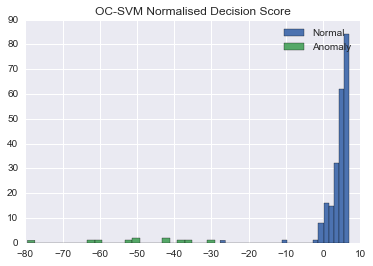

In [49]:
plt.hist(svmScore(data[label == +1, :], res.x[0:-1]) - res.x[-1], bins = 25, label = 'Normal');
plt.hist(svmScore(data[label == -1, :], res.x[0:-1]) - res.x[-1], bins = 25, label = 'Anomaly');
plt.legend(loc = 'upper right');
plt.title('OC-SVM Normalised Decision Score');

## OC-SVM sklearn

Comparison to sklearn implementation of OC-SVM.

In [50]:
from sklearn import svm

nu = 0.04
ocSVM = svm.OneClassSVM(nu = nu, kernel = 'linear')
ocSVM.fit(data_train) 

decisionScore = ocSVM.decision_function(data)

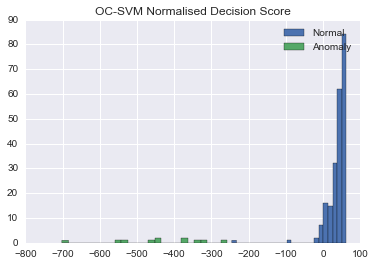

In [51]:
plt.hist(decisionScore[label == +1], bins = 25, label = 'Normal');
plt.hist(decisionScore[label == -1], bins = 25, label = 'Anomaly');
plt.legend(loc = 'upper right');
plt.title('OC-SVM Normalised Decision Score');

## OC-NN explicit

Define the OC-NN objective function as per the notes. It accepts the activation g(.) as an argument as well.

In [52]:
def nnScore(X, w, V, g):
    return g(X.dot(V)).dot(w)

def ocnn_obj(theta, X, nu, D, K, g, dG):
    
    w = theta[:K]
    V = theta[K:K+K*D].reshape((D, K))
    r = theta[K+K*D:]
    
    term1 = 0.5  * np.sum(w**2)
    term2 = 0.5  * np.sum(V**2)
    term3 = 1/nu * np.mean(relu(r - nnScore(X, w, V, g)))
    term4 = -r
    
    return term1 + term2 + term3 + term4

def ocnn_grad(theta, X, nu, D, K, g, dG):
    
    N = X.shape[0]
    w = theta[:K]
    V = theta[K:K+K*D].reshape((D, K))
    r = theta[K+K*D:]
    
    deriv = dRelu(r - nnScore(X, w, V, g))    

    term1 = np.concatenate(( w,
                             np.zeros((V.size,)),
                             np.zeros((1,)) ))

    term2 = np.concatenate(( np.zeros((w.size,)),
                             V.flatten(),
                             np.zeros((1,)) ))

    term3 = np.concatenate(( 1/nu * np.mean(deriv[:,np.newaxis] * (-g(X.dot(V))), axis = 0),
                             1/nu * np.mean((deriv[:,np.newaxis] * (dG(X.dot(V)) * -w)).reshape((N, 1, K)) * X.reshape((N, D, 1)), axis = 0).flatten(),
                             1/nu * np.array([ np.mean(deriv) ]) ))
    
    term4 = np.concatenate(( np.zeros((w.size,)),
                             np.zeros((V.size,)),
                             -1 * np.ones((1,)) ))
    
    return term1 + term2 + term3 + term4

### Linear activation

Minimise objective explicitly for some small number of hidden units.

In [53]:
from scipy.optimize import minimize

X  = data_train
D  = X.shape[1]
K  = 4
nu = 0.04

g  = lambda x : x
dG = lambda x : np.ones(x.shape)

np.random.seed(42)
theta0 = np.random.normal(0, 1, K + K*D + 1)

from scipy.optimize import check_grad
print('Gradient error: %s' % check_grad(ocnn_obj, ocnn_grad, theta0, X, nu, D, K, g, dG))

res = minimize(ocnn_obj, theta0, method = 'L-BFGS-B', jac = ocnn_grad, args = (X, nu, D, K, g, dG),
               options = {'gtol': 1e-8, 'disp': True, 'maxiter' : 50000, 'maxfun' : 10000})

Gradient error: 0.00032003848362


In [54]:
thetaStar = res.x

wStar = thetaStar[:K]
VStar = thetaStar[K:K+K*D].reshape((D, K))
rStar = thetaStar[K+K*D:]

In [55]:
# print('rStar vs percentile:')
# print((rStar[0], np.percentile(nnScore(data_train, wStar, VStar, g), q = 100 * nu)))

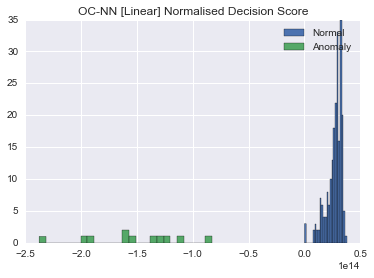

In [56]:
plt.hist(nnScore(data[label == +1], wStar, VStar, g) - rStar, bins = 25, label = 'Normal');
plt.hist(nnScore(data[label == -1], wStar, VStar, g) - rStar, bins = 25, label = 'Anomaly');
plt.legend(loc = 'upper right');
plt.title('OC-NN [Linear] Normalised Decision Score');

### Sigmoid activation

In [57]:
from scipy.optimize import minimize

X  = data_train
D  = X.shape[1]
K  = 4
nu = 0.04

g   = lambda x : 1/(1 + np.exp(-x))
dG  = lambda x : 1/(1 + np.exp(-x)) * 1/(1 + np.exp(+x))

np.random.seed(42)
theta0 = np.random.normal(0, 1, K + K*D + 1)

from scipy.optimize import check_grad
print('Gradient error: %s' % check_grad(ocnn_obj, ocnn_grad, theta0, X, nu, D, K, g, dG))

res = minimize(ocnn_obj, theta0, method = 'L-BFGS-B', jac = ocnn_grad, args = (X, nu, D, K, g, dG),
               options = {'gtol': 1e-8, 'disp': True, 'maxiter' : 50000, 'maxfun' : 10000})

Gradient error: 8.33498126439e-05


In [58]:
# thetaStar = res.x

# wStar = thetaStar[:K]
# VStar = thetaStar[K:K+K*D].reshape((D, K))
# rStar = thetaStar[K+K*D:]

In [59]:
thetaStar = theta0

wStar = thetaStar[:K]
VStar = thetaStar[K:K+K*D].reshape((D, K))
rStar = thetaStar[K+K*D:]

In [62]:
print wStar
print VStar

[ 0.49671415 -0.1382643   0.64768854  1.52302986]
[[-0.23415337 -0.23413696  1.57921282  0.76743473]
 [-0.46947439  0.54256004 -0.46341769 -0.46572975]
 [ 0.24196227 -1.91328024 -1.72491783 -0.56228753]
 ..., 
 [-0.651418   -0.48388583 -0.32034731  0.42416595]
 [ 0.52283549 -0.5737     -0.02435459  2.14227036]
 [ 1.72754317  0.43632367  0.03800348  0.12003133]]


In [60]:
# print('rStar vs percentile:')
# print((rStar[0], np.percentile(nnScore(data_train, wStar, VStar, g), q = 100 * nu)))

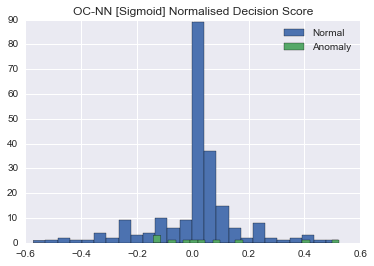

In [61]:
plt.hist(nnScore(data[label == +1], wStar, VStar, g) - rStar, bins = 25, label = 'Normal');
plt.hist(nnScore(data[label == -1], wStar, VStar, g) - rStar, bins = 25, label = 'Anomaly');
plt.legend(loc = 'upper right');
plt.title('OC-NN [Sigmoid] Normalised Decision Score');

### Tflearn based Code for OC-NN 

Training Step: 599  | total loss: 0.00174 | time: 0.007s
| SGD | epoch: 200 | loss: 0.00174 - binary_acc: 1.0000 -- iter: 200/220
Training Step: 600  | total loss: 0.00174 | time: 0.011s
| SGD | epoch: 200 | loss: 0.00174 - binary_acc: 1.0000 -- iter: 220/220
--
Hideen [[ -4.98954214e-05  -8.29289183e-06   7.45984507e-05  -4.29097927e-05]
 [ -6.73346076e-05   4.92666259e-05  -7.67769961e-05  -1.34297370e-04]
 [ -1.46113698e-05  -1.32730900e-04  -1.70264364e-04  -1.41452882e-04]
 ..., 
 [ -8.07425531e-05  -2.68223666e-05  -6.60758014e-05  -6.81170422e-05]
 [  6.25834582e-06  -3.34725264e-05  -4.41674347e-05   5.91446769e-05]
 [  9.55018913e-05   4.13881899e-05  -3.95919451e-05  -9.08271250e-05]]
[[ 1.31013346]
 [ 1.30986619]
 [ 1.31075859]
 [ 1.30934143]]


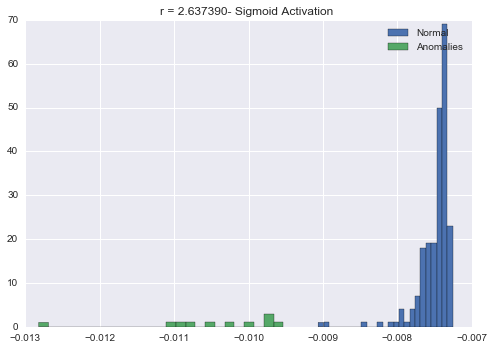

In [2]:
from tflearn import DNN
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression, oneClassNN
import tensorflow as tf
import tflearn
import numpy as np
import tflearn.variables as va
import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as srn

from data_fetch import prepare_usps_mlfetch

[Xtrue,Xlabels] = prepare_usps_mlfetch()

data  = Xtrue
label = Xlabels
data_train    = data[0:220]
data_test     = data[220:231]
targets_train = label[0:220]
targets_test  = label[220:231]
# Clear all the graph variables created in previous run and start fresh
# tf.reset_default_graph()

## Set up the data for running the algorithm
data_train = data[0:220]
target = Xlabels
X = data_train
Y = targets_train
Y = Y.tolist()
Y = [[i] for i in Y]

# For testing the algorithm
X_test = data_test
Y_test = targets_test
Y_test = Y_test.tolist()
Y_test = [[i] for i in Y_test]

No_of_inputNodes = X.shape[1]
K = 4
nu = 0.04
D = X.shape[1]

# Define the network
input_layer = input_data(shape=[None, No_of_inputNodes])  # input layer of size

np.random.seed(42)
theta0 = np.random.normal(0, 1, K + K*D + 1) *0.0001
#theta0 = np.random.normal(0, 1, K + K*D + 1) # For linear
hidden_layer = fully_connected(input_layer, 4, bias=False, activation='sigmoid', name="hiddenLayer_Weights",
                               weights_init="normal")  # hidden layer of size 2


output_layer = fully_connected(hidden_layer, 1, bias=False, activation='linear', name="outputLayer_Weights",
                               weights_init="normal")  # output layer of size 1



# Hyper parameters for the one class Neural Network
v = 0.04
nu = 0.04

# Initialize rho
value = 0.01
init = tf.constant_initializer(value)
rho = va.variable(name='rho', dtype=tf.float32, shape=[], initializer=init)

rcomputed = []
auc = []


sess = tf.Session()
sess.run(tf.initialize_all_variables())
print sess.run(tflearn.get_training_mode()) #False
tflearn.is_training(True, session=sess)
print sess.run(tflearn.get_training_mode())  #now True

X  = data_train
D  = X.shape[1]
nu = 0.04




# temp = np.random.normal(0, 1, K + K*D + 1)[-1]

temp = theta0[-1]

# temp = tflearn.variables.get_value(rho, session=sess)

oneClassNN = oneClassNN(output_layer, v, rho, hidden_layer, output_layer, optimizer='sgd',
                        loss='OneClassNN_Loss',
                            learning_rate=1)

model = DNN(oneClassNN, tensorboard_verbose=3)

model.set_weights(output_layer.W, theta0[0:K][:,np.newaxis])
model.set_weights(hidden_layer.W, np.reshape(theta0[K:K +K*D],(D,K)))


iterStep = 0
while (iterStep < 100):
    print "Running Iteration :", iterStep
    # Call the cost function
    y_pred = model.predict(data_train)  # Apply some ops
    tflearn.is_training(False, session=sess)
    y_pred_test = model.predict(data_test)  # Apply some ops
    tflearn.is_training(True, session=sess)
    value = np.percentile(y_pred, v * 100)
    tflearn.variables.set_value(rho, value,session=sess)
    rStar = rho
    model.fit(X, Y, n_epoch=2, show_metric=True, batch_size=100)
    iterStep = iterStep + 1
    rcomputed.append(rho)
    temp = tflearn.variables.get_value(rho, session=sess)

    # print "Rho",temp
    # print "y_pred",y_pred
    # print "y_predTest", y_pred_test

# g = lambda x: x
g   = lambda x : 1/(1 + tf.exp(-x))

def nnScore(X, w, V, g):
    return tf.matmul(g((tf.matmul(X, w))), V)


# Format the datatype to suite the computation of nnscore
X = X.astype(np.float32)
X_test = data_test
X_test = X_test.astype(np.float32)
# assign the learnt weights
# wStar = hidden_layer.W
# VStar = output_layer.W
# Get weights values of fc2
wStar = model.get_weights(hidden_layer.W)
VStar = model.get_weights(output_layer.W)

print "Hideen",wStar
print VStar

train = nnScore(X, wStar, VStar, g)
test = nnScore(X_test, wStar, VStar, g)

# Access the value inside the train and test for plotting
# Create a new session and run the example
# sess = tf.Session()
# sess.run(tf.initialize_all_variables())
arrayTrain = train.eval(session=sess)
arrayTest = test.eval(session=sess)

# print "Train Array:",arrayTrain
# print "Test Array:",arrayTest

plt.hist(arrayTrain-temp,  bins = 25,label='Normal');
plt.hist(arrayTest-temp, bins = 25, label='Anomalies');
plt.legend(loc='upper right')
plt.title('r = %1.6f- Sigmoid Activation ' % temp)
plt.show()
